In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import utils as utils
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import ipywidgets as widgets

<AxesSubplot:>

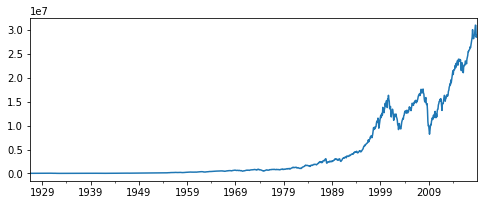

In [2]:
periods_per_year = 12

# Industry Returns
ind_returns = utils.read_ind30()

# Average cap size of firms in each industry
ind_avg_cap_size = utils.read_avg_cap_size()

# Number of firms in each industry
ind_num_firms = utils.read_num_firms()

# Industry cap size = avg. cap size x # of firms
ind_cap_size = ind_num_firms * ind_avg_cap_size

# Total market cap by time
total_mkt_cap = ind_cap_size.sum(axis=1)
total_mkt_cap.plot.line(figsize=(8, 3))

<AxesSubplot:>

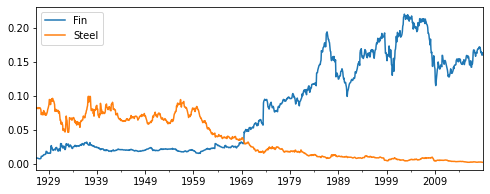

In [3]:
# industry cap weight
ind_cap_weight = ind_cap_size.divide(total_mkt_cap, axis=0)
ind_cap_weight[["Fin", "Steel"]].plot.line(figsize=(8, 3))

<AxesSubplot:title={'center':'Total Market CapWeighted 1926-2018'}>

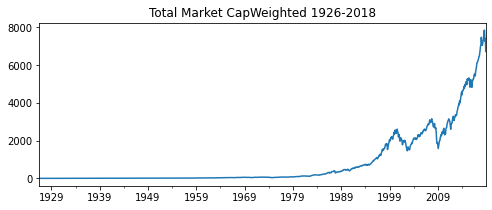

In [4]:
# total market return
tot_mkt_return = utils.total_mkt_return(ind_returns, ind_avg_cap_size, ind_num_firms)
tot_mkt_wealth_index = (1 + tot_mkt_return).cumprod()
tot_mkt_wealth_index.plot.line(figsize=(8, 3), title='Total Market CapWeighted 1926-2018')

<AxesSubplot:>

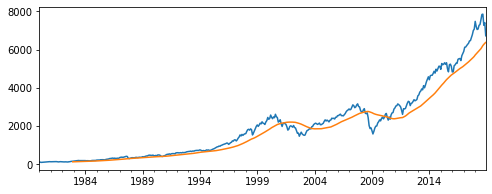

In [5]:
tot_mkt_wealth_index['1980':].plot(figsize=(8, 3))
tot_mkt_wealth_index['1980':].rolling(36).mean().plot(figsize=(8, 3))

### Rolling correlation between industries (trailing 36 months)

- As return of the market portfolio falls, we can see that the correlation between the assets increase. This demonstrates that diversity can't remove systematic risks. 
- In other words, when the market portfolio's returns are following => returns are decreasing ubiquitosly across the market. 
- On the other hand, market growth is a result of more independent or orthogonal increases from assets. 

-0.280100650628841


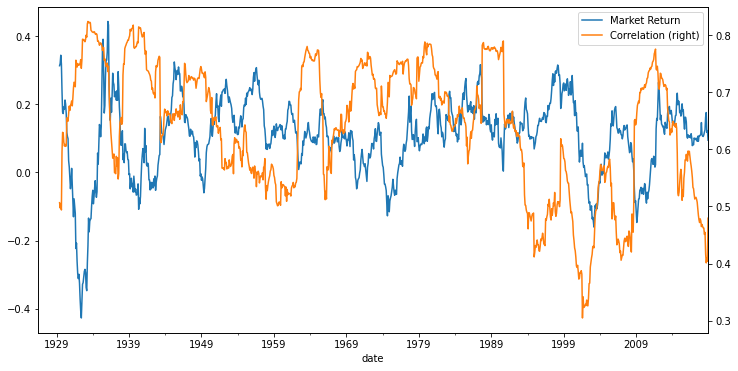

In [6]:
# pairwise correlations between industries for 36 month windows
tr36m_corr = ind_returns.rolling(window=36).corr()
tr36m_corr.index.names = ['date', 'industry']
tr36m_mean_corr = tr36m_corr.groupby('date').apply(lambda corr_mat: corr_mat.values.mean())
tr36m_annualized_return = tot_mkt_return.rolling(36).apply(lambda x: utils.annual_return(x, periods_per_year))

tr36m_annualized_return.plot.line(legend=True, figsize=(12, 6), label="Market Return")
tr36m_mean_corr.plot.line(legend=True, label='Correlation', secondary_y=True)
print(tr36m_annualized_return.corr(tr36m_mean_corr))

### Constant Portfolio Proportion Insurance (CPPI) Algorithm

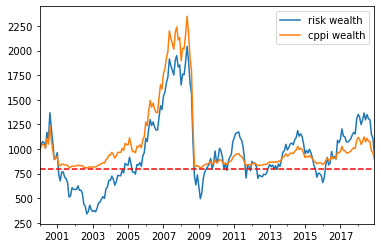

In [7]:
ind_return = utils.read_ind30()
tot_mkt_return = utils.total_mkt_return(ind_returns, ind_avg_cap_size, ind_num_firms)

# risky assets
industries = ["Steel", "Fin", "Beer"]
num_industries = len(industries)
risky_return = ind_return["2000":][industries]

# safe assets
safe_return = pd.DataFrame().reindex_like(risky_return)
safe_return[:] = 0.03/12

# start - (beginning value of assets)
start = np.repeat(1000, num_industries)
floor = np.repeat(0.8, num_industries)
m = 3 # multiplier multiplied to cushion

dates = risky_return.index
account_value = start
floor_value = start*floor
account_history = pd.DataFrame().reindex_like(risky_return)
cushion_history = pd.DataFrame().reindex_like(risky_return)
risky_history = pd.DataFrame().reindex_like(risky_return)

for date in dates:
    cushion = (account_value - floor_value)/account_value
    
    # compute proportions of account value that will be invested in risky & safe
    risky_weight = m*cushion
    
    # if the risky_weight exceeds 1, then replace as 1
    risky_weight[risky_weight > 1] = 1
    
    safe_weight = 1 - risky_weight
    risky_alloc = account_value * risky_weight
    safe_alloc = account_value * safe_weight
        
    # extract risky return & safe return at each timestep
    risky_r_step = 1 + risky_return.loc[date]
    safe_r_step = 1 + safe_return.loc[date]
    
    # multiply investments by returns
    account_value =  risky_alloc * risky_r_step + safe_alloc * safe_r_step
    account_history.loc[date] = account_value

risk_wealth = 1000*(1 + risky_return["Steel"]).cumprod()
risk_wealth.plot.line(label='risk wealth', legend=True)
account_history["Steel"].plot.line(label="cppi wealth", legend=True)
plt.axhline(floor_value[0], color='red', linestyle='--')

### CPPI Algorithm with drawdown constraint

In [8]:
ind_return = utils.read_ind30()
tot_mkt_return = utils.total_mkt_return(ind_returns, ind_avg_cap_size, ind_num_firms)

# risky assets
industries = ["Steel", "Fin", "Beer"]
num_industries = len(industries)
risky_return = ind_return["2000":][industries]
cppi_returns = list()

# safe assets
safe_return = pd.DataFrame().reindex_like(risky_return)
safe_return[:] = 0.03/12

# start - (beginning value of assets)
start = np.repeat(1000, num_industries)
floor = np.repeat(0.8, num_industries)
m = 3 # multiplier multiplied to cushion
peak = start
drawdown = 0.1

dates = risky_return.index
account_value = start
floor_value = start*floor
account_history = pd.DataFrame().reindex_like(risky_return)
cppi_return_history = pd.DataFrame().reindex_like(risky_return)
risky_history = pd.DataFrame().reindex_like(risky_return)

for date in dates:
    
    # if drawdown is set, the floor_value is the maximum acceptable drawdown
    if drawdown is not None:
        floor_value = (1 - drawdown) * peak
    
    cushion = (account_value - floor_value)/account_value
    
    # compute proportions of account value that will be invested in risky & safe
    risky_weight = m*cushion
    
    # if the risky_weight exceeds 1, then replace as 1
    risky_weight[risky_weight > 1] = 1
    
    safe_weight = 1 - risky_weight
    risky_alloc = account_value * risky_weight
    safe_alloc = account_value * safe_weight
        
    # extract risky return & safe return at each timestep
    risky_r_step = 1 + risky_return.loc[date]
    safe_r_step = 1 + safe_return.loc[date]
    r_step = risky_weight*risky_return.loc[date] + safe_weight*safe_return.loc[date]
    
    # multiply investments by returns
    account_value =  risky_alloc * risky_r_step + safe_alloc * safe_r_step
    account_history.loc[date] = account_value
    cppi_return_history.loc[date] = r_step
    
    # overwrite the peaks
    peak[peak < account_value] = account_value[peak<account_value]

<AxesSubplot:>

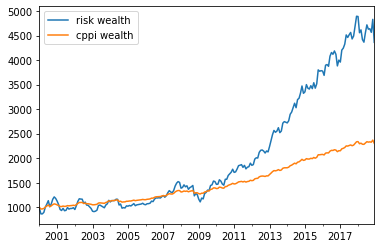

In [9]:
risk_wealth = 1000*(1 + risky_return["Beer"]).cumprod()
risk_wealth.plot.line(label='risk wealth', legend=True)
account_history["Beer"].plot.line(label="cppi wealth", legend=True)

### Notice that the max drawdown does not fall below the drawdown paramter (0.1)

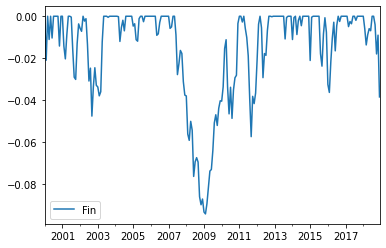

In [10]:
drawdown = utils.compute_drawdown(cppi_return_history[['Fin']], plot=True)

## Interactive Modeling Stock Prices as a Sochastic Brownian Process

In [11]:
# geometric brownian motion
def gbm(n_years=10, n_scenarios=20, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100, set_zero=True):
    
    dt = 1/steps_per_year
    num_steps = n_years * steps_per_year
    zi = np.random.normal(size=(num_steps, n_scenarios))
    returns = mu*dt + sigma*np.sqrt(dt)*zi
    if set_zero:
        returns[0, :] = 0
    returns = pd.DataFrame(returns)
    prices = s_0*(1+returns).cumprod()
    return prices, returns

def show_gbm(n_scenarios, mu, sigma):
    s_0 = 100
    prices, returns = gbm(n_years=10, n_scenarios=n_scenarios, mu=mu, sigma=sigma, steps_per_year=12, s_0=s_0)
    ax = prices.plot.line(color='indianred', linewidth=2, figsize=(12, 6), legend=False, xlim=0)
    ax.axhline(y=s_0, ls=':', color='black')
    

### ipywidget example

In [12]:
widgets.interact(show_gbm, 
                 n_scenarios=(0, 200, 1),
                 mu=(-1, 1, 0.01),
                 sigma=(0, 1, 0.01)
                )

interactive(children=(IntSlider(value=100, description='n_scenarios', max=200), FloatSlider(value=0.0, descrip…

<function __main__.show_gbm(n_scenarios, mu, sigma)>

## Interactive Modeling of CPPI Algorithm

In [18]:
def cppi(m=3, 
         rf_rate=0.03,
         s_0=100,
         n_scenarios=30, 
         mu=0.07, 
         sigma=0.15, 
         set_zero=False,
         floor_value=0.8,
         drawdown=None):
    
    # use geometric brownian motion to model the risky returns
    _, risky_r = gbm(n_scenarios=n_scenarios, mu=mu, sigma=sigma, s_0=s_0, set_zero=set_zero)

    # set the starting account value and floor value
    start = np.repeat(s_0, n_scenarios)
    floor_value = floor_value*start
    peak = start
    account_value = start
    
    # safe returns are fixed returns
    safe_r = pd.DataFrame().reindex_like(risky_r)
    safe_r[:] = rf_rate/12

    account_history = pd.DataFrame().reindex_like(risky_r)
    return_history = pd.DataFrame().reindex_like(risky_r)
    risk_weight_history = pd.DataFrame().reindex_like(risky_r)

    for i in risky_r.index:    
        if drawdown:
            floor_value = (1 - drawdown)*peak 

        # use the cushion to compute the allocation towards the risky asset & safe asset
        cushion = (account_value - floor_value)/account_value
        risk_weight = m*cushion
        risk_weight[risk_weight > 1] = 1
        safe_weight = 1 - risk_weight

        # compute the total return at timestep i 
        risky_return = risky_r.loc[i]
        safe_return = safe_r.loc[i]
        tot_return = risk_weight*risky_return + safe_return*safe_weight

        return_history.loc[i] = tot_return
        account_value = account_value*(1+tot_return)
        account_history.loc[i] = account_value
        risk_weight_history.loc[i] = risk_weight
    
    # set the first price as the start value
    account_history.loc[0] = s_0
    return account_history, return_history, risk_weight_history

def show_cppi(m,
              rf_rate,
              s_0,
              n_scenarios, 
              mu, 
              sigma, 
              floor_value):
    
    account_history, return_history, risk_weight_history = cppi(m=m, 
                                                                rf_rate=rf_rate,
                                                                s_0=s_0,
                                                                n_scenarios=n_scenarios, 
                                                                mu=mu, 
                                                                sigma=sigma, 
                                                                floor_value=floor_value
                                                               )
    
    ax = account_history.plot.line(color="indianred", figsize=(12, 6), legend=False)
    ax.axhline(floor_value*s_0)
    plt.xlim(0)



In [19]:
widgets.interact(show_cppi,
                 m=(0, 8, 0.1), 
                 rf_rate=(0, 0.1, 0.01),
                 s_0=(100, 200, 1),
                 n_scenarios=(30,  100, 1),
                 mu=(-1, 1, 0.01), 
                 sigma=(0, 1, 0.01), 
                 floor_value=(0, 0.9, 0.01)
                )

interactive(children=(FloatSlider(value=4.0, description='m', max=8.0), FloatSlider(value=0.05, description='r…

<function __main__.show_cppi(m, rf_rate, s_0, n_scenarios, mu, sigma, floor_value)>